# Anomaly Detection

In [3]:
# import library

import numpy as np
import pandas as pd 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [4]:
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [5]:
# import data

data = pd.read_csv("creditcard.csv", sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info

<bound method DataFrame.info of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  

### Exploratory Data Analysis

In [7]:
data.isnull().values.any()

False

/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_3902/2089979038.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data["Class"], sort=True)


Text(0, 0.5, 'Frequency')

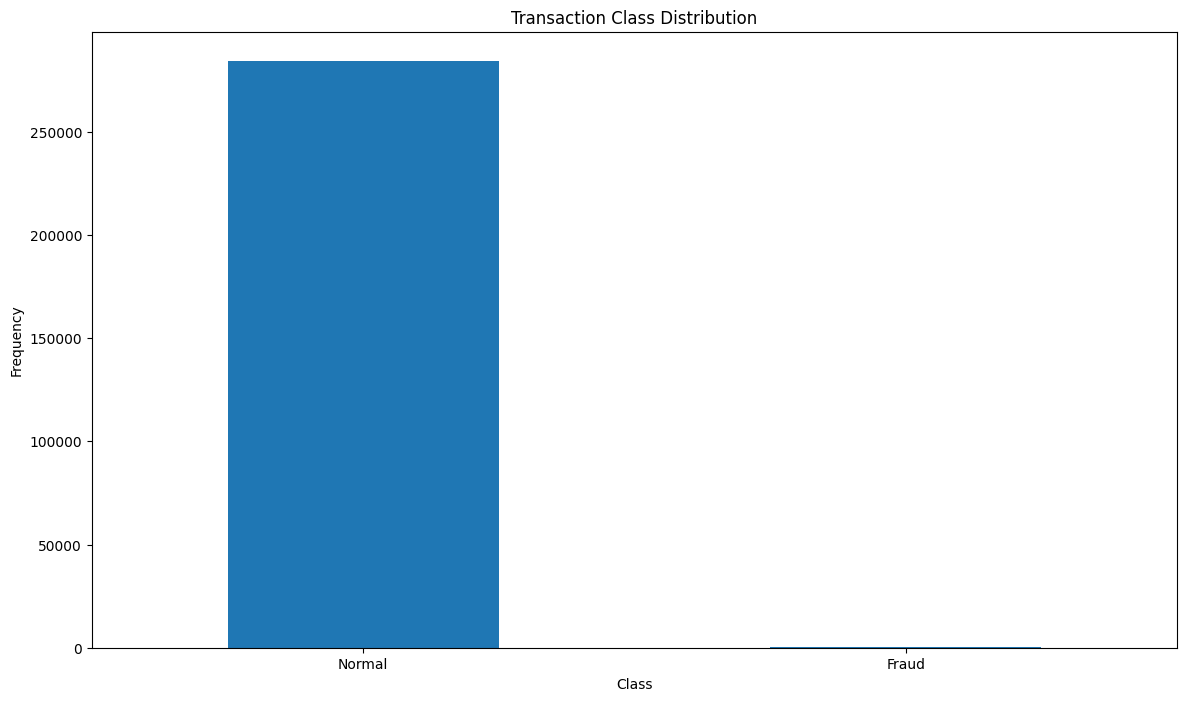

In [8]:
count_classes = pd.value_counts(data["Class"], sort=True)

count_classes.plot(kind='bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [9]:
fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [10]:
print(fraud.shape, normal.shape)

(492, 31) (284315, 31)


In [13]:
print(normal["Amount"].describe())
print(fraud["Amount"].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


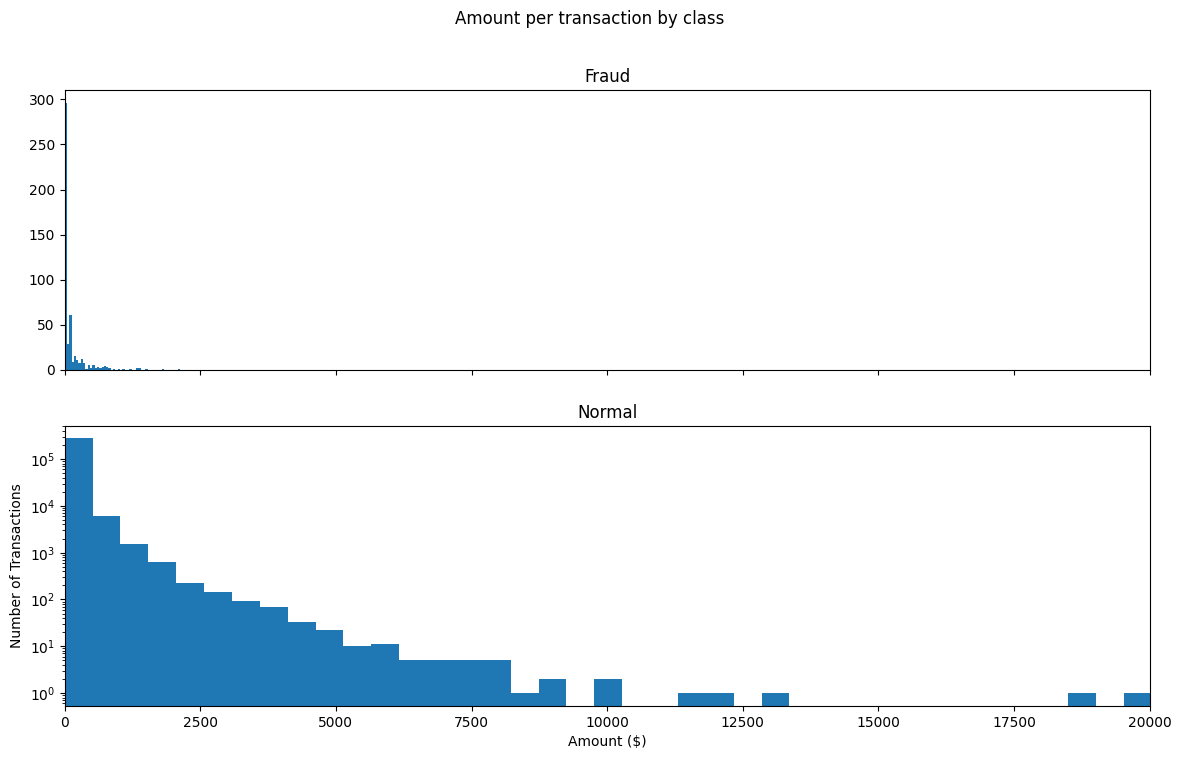

In [14]:
f1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

f1.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraud["Amount"], bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal["Amount"], bins = bins)
ax2.set_title("Normal")

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

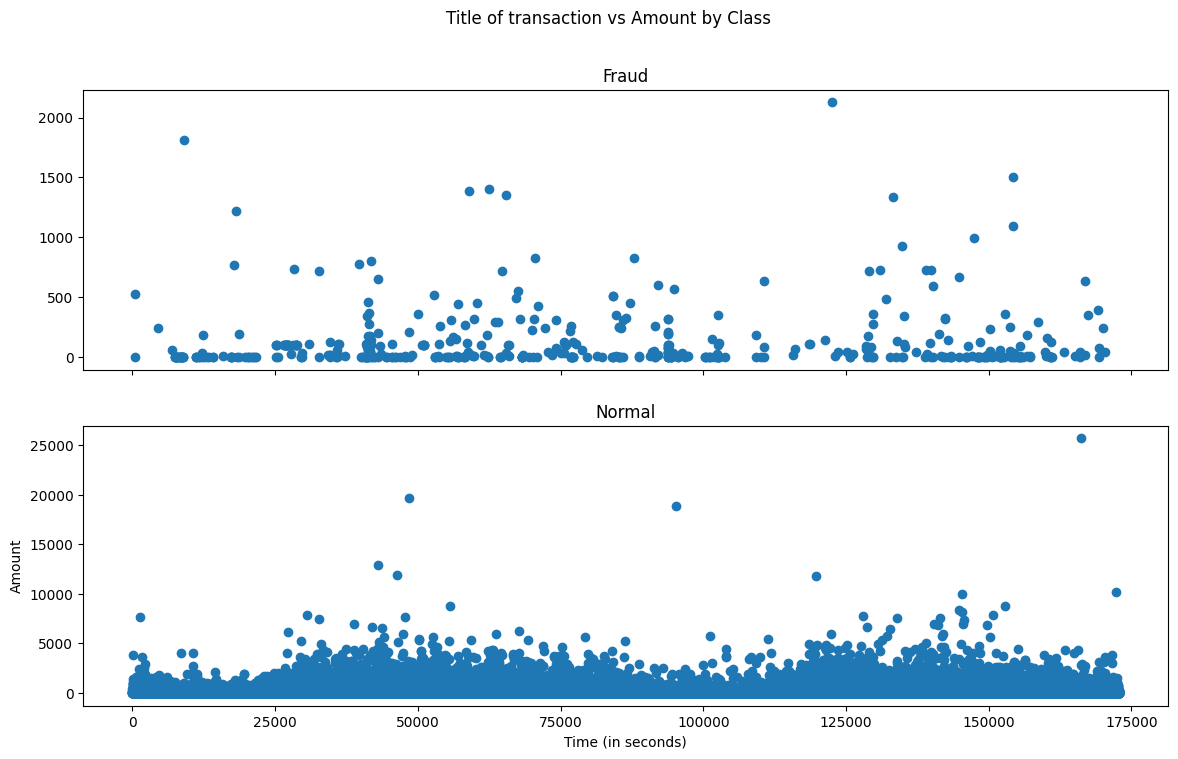

In [15]:
f2, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f2.suptitle('Title of transaction vs Amount by Class')

ax1.scatter(fraud["Time"], fraud["Amount"])
ax1.set_title('Fraud')

ax2.scatter(normal["Time"], normal["Amount"])
ax2.set_title('Normal')

plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [17]:
# Déterminer la portion de fraude dans le jeu de données
outlier_fraction = len(fraud) / float(len(normal))
print(outlier_fraction)

print(" Fraude : {}".format(len(fraud)))

print(" Normal : {}".format(len(normal)))

0.0017304750013189597
 Fraude : 492
 Normal : 284315


<Axes: >

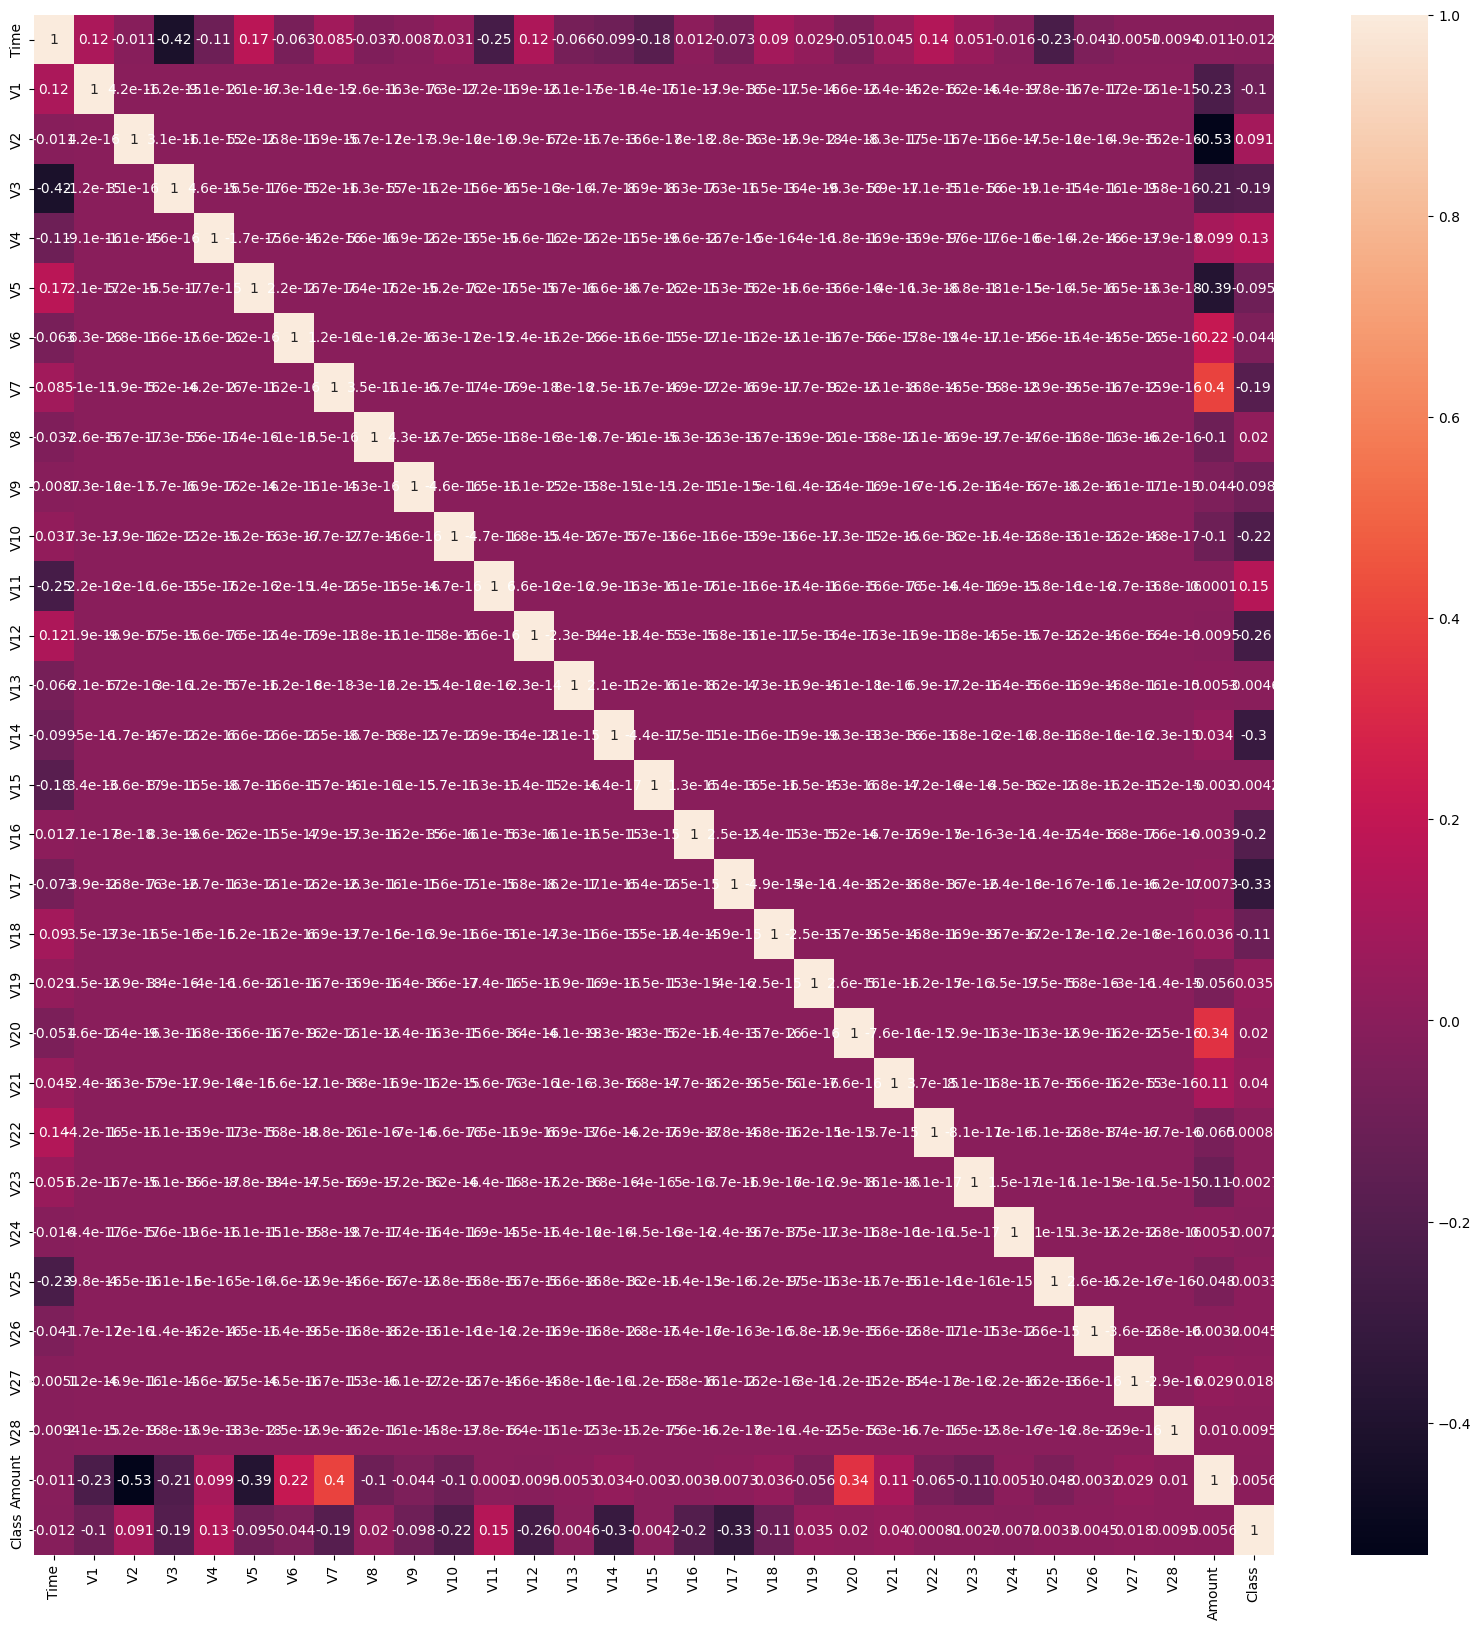

In [20]:
# Corrélation
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Afficher la matrice de corrélation
sns.heatmap(data[top_corr_features].corr(), annot=True)

### Pre-processing steps

In [21]:
# Définir la variable cible et les variables explicatives

target = "Class" # cible

X = data.drop([target], axis=1)
y = data[target]

### Modelling

Different machine learnin models used to make prediction. 
There are : 
- Isolation Forest Algorithm
- Local Outlier Factor (LOF) Algorithm
- OneClassSVM

In [22]:
## Définir les modèles

classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples=len(X),
                                        contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                               leaf_size=30, metric='minkowski',
                                               p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05,
                                          max_iter=-1)
    
}

In [24]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
    else :
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    y_pred[y_pred == 1] == 0
    y_pred[y_pred == -1] == 1
    
    n_errors = (y_pred != y).sum()
    
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print("Classification Report :")
    print(classification_report(y, y_pred))
    

Isolation Forest: 284471
Accuracy Score :
0.0011797462843258768
Classification Report :


/Users/ranu/Data-Science-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ranu/Data-Science-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ranu/Data-Science-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00    284315
           1       0.00      0.68      0.00       492

    accuracy                           0.00    284807
   macro avg       0.00      0.23      0.00    284807
weighted avg       0.00      0.00      0.00    284807

